In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from scipy.signal import resample
import random
np.random.seed(42)

import torch
import torch.nn as nn
from torch.optim import Adam

torch.manual_seed(42)
torch.backends.cudnn.benchmark = False

The following code will make graphs a bit easier to read and display.

In [15]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.grid':True,
         'axes.grid.which':'both'
         }
plt.rcParams.update(params)

## Read Dataset
The default dataset comes in two sets - Training set and Testing set. We combine the two and redistribute to three sets.

In [16]:
df = pd.read_csv("/Users/daniela/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/Spring 2023/FPGA/Project/archive/mitbih_train.csv", header=None)
df2 = pd.read_csv("/Users/daniela/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/Spring 2023/FPGA/Project/archive/mitbih_test.csv", header=None)

df = df.reset_index().drop('index', axis='columns')

#print(df)


In [17]:
label_names = {0 : 'N',
              1: 'S',
              2: 'V',
              3: 'F',
              4 : 'Q'}

## Data augmentation

We use an existing data augmentation class for stretching and amplifying our samples from the dataset

In [18]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor


class Stretch:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return stretch(x)
    
    def __repr__(self):
        return 'Stretch'
    
class Amplify:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return amplify(x)
    
    def __repr__(self):
        return 'Amplify'

class Augment:
    def __init__(self, augmentation_list, return_prints = False):
        self.augmentation_list = augmentation_list
        self.return_prints = return_prints
        
    def __call__(self, x):
        augmentations_performed = ''
        
        for augmentation in self.augmentation_list:
            if np.random.binomial(1, 0.5) == 1:
                x = augmentation(x)
                augmentations_performed += f'{augmentation} '
                
        if not self.return_prints:
            return x
        return x, augmentations_performed



## Split Dataset into Train-, Validation- and Test-set

Next we devide the data to three sets - train set, validation set and test set - but we do so such that the probability of every class in each set is similar to the probability in the undivided set.

In [19]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, train_size=0.8, stratify=df.iloc[:,-1])
test_df = df2
# Make sure the target distribution stays the same...
for temp_df in [train_df, val_df, test_df]:
    print(temp_df.shape[0], temp_df.shape[0] / df.shape[0])
    print(temp_df.iloc[:,-1].value_counts(normalize=True))
    print('\n')

70043 0.7999977156954565
0.0    0.827734
4.0    0.073455
2.0    0.066102
1.0    0.025384
3.0    0.007324
Name: 187, dtype: float64


17511 0.20000228430454348
0.0    0.827708
4.0    0.073440
2.0    0.066130
1.0    0.025413
3.0    0.007310
Name: 187, dtype: float64


21892 0.25003997532951094
0.0    0.827608
4.0    0.073451
2.0    0.066143
1.0    0.025397
3.0    0.007400
Name: 187, dtype: float64




### Undersample the over-represented
There is a huge imbalance. The model can easily diminish the loss by ignoring everything other than class 0.
There are several ways to handle this - oversample, undersample, bootstrapping etc.
First, we look at the distribution of samples in the training set:

Next we take the over represented class (N) and sample 5000 samples, randomly. These will be used for training and the rest are ignored.

/var/folders/v4/jjwmcn596mdfrxzdn2dhp_540000gn/T/ipykernel_45485/623412903.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = non_normal_rows.append(normal_rows)


187
0.0    5000
1.0    1778
2.0    4630
3.0     513
4.0    5145
dtype: int64

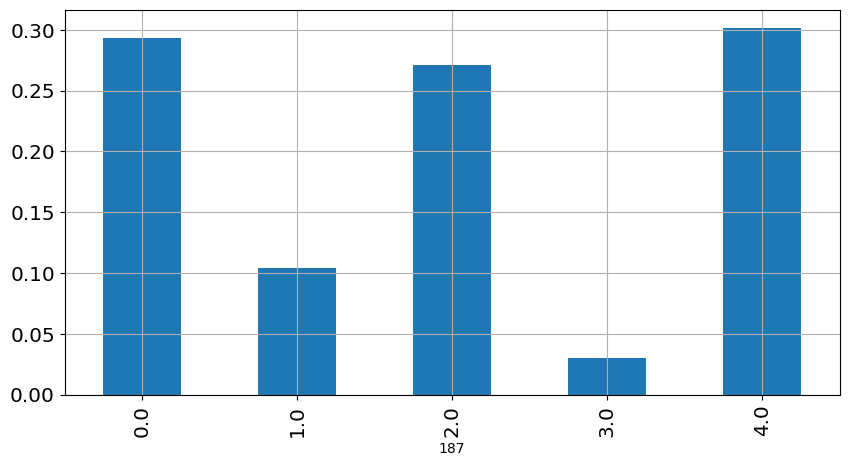

In [20]:
non_normal_rows = train_df.loc[train_df.iloc[:,-1] != 0]
normal_rows = train_df.loc[train_df.iloc[:,-1] == 0].sample(5000)

train_df = non_normal_rows.append(normal_rows)

col = train_df.groupby(187).size()
(col / col.sum()).plot.bar()
col


## Build Model
The model is based off two existing models, but we have created a simplified version of it

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding='same')   
        self.max1 = nn.MaxPool1d(kernel_size=5, stride=2) 
        self.conv2 = nn.Conv1d(32, 32, kernel_size=5, padding = 'same')
        self.max2 = nn.MaxPool1d(kernel_size=5, stride=2) 
        self.conv3 = nn.Conv1d(32, 32, kernel_size=5, padding = 'same')
        self.max3 = nn.MaxPool1d(kernel_size=5, stride=2) 
        self.conv4 = nn.Conv1d(32, 32, kernel_size=5, padding = 'same')
        self.max4 = nn.MaxPool1d(kernel_size=5, stride=2) 
        self.max5 = nn.MaxPool1d(kernel_size=5, stride=2) 

        self.dense1 = nn.Linear(64,32)
        self.acc = nn.ReLU()
        self.dense2 = nn.Linear(32,5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.acc(x)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.acc(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.acc(x)
        x = self.max3(x)
        x = self.conv4(x)
        x = self.acc(x)
        x = self.max4(x)
        x = self.max5(x)

        x = x.view(x.shape[0], -1) #flattens
        x = self.dense1(x)
        x = self.acc(x)
        x = self.dense2(x)
        
        return x

Here we set the batch_size, epochs, lr, and number of splits (folds) for training. After trying different values, these numbers led to a better trained model. 

In [22]:
batch_size = 256
epochs = 10 
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_splits = 10

Now we define helper methods for data handling. These will be very helpfull to divide the data to batches, shuffle and randomize and do computations in parallel. 

In [23]:
from torch.utils.data import Dataset, DataLoader

class ds(Dataset):
  def __init__(self, x, y=None, transforms=None):
    super().__init__()

    self.X = x
    self.Y = y
    self.transforms = transforms

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self,idx):
    x = self.X.iloc[idx,:]
    
    if self.transforms is not None:
        x = self.transforms(x)

    if self.Y is not None:
      return torch.Tensor(x).view(1,-1).float(), torch.Tensor([self.Y.iloc[idx]]).float().squeeze()

    return torch.Tensor(x).float()

augment = Augment([Amplify(), Stretch()])

train_set = ds(train_df.iloc[:,:-1], train_df.iloc[:,-1], transforms=augment)
val_set = ds(val_df.iloc[:,:-1], val_df.iloc[:,-1])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size*4)

## Train Model


In [24]:
criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import ReduceLROnPlateau

Here we use Adam optimizer, which converges faster better than SGD. 


In [25]:
epoch_train_losses = []
epoch_val_losses = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=n_splits)
for fold_n, (train_idx, val_idx) in enumerate(kf.split(df)):
    train_set = ds(df.iloc[train_idx,:-1], df.iloc[train_idx,-1], transforms=augment)
    val_set = ds(df.iloc[val_idx,:-1], df.iloc[val_idx,-1])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size*4)
    
    model = Model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_sched = ReduceLROnPlateau(optimizer, patience=3)
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0

        model.train()
        for batch_id, (x,y_true) in enumerate(train_loader):
            y_pred = model(x.to(device))

            optimizer.zero_grad()
            loss = criterion(y_pred, y_true.long().to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() / len(train_loader)

        model.eval()
        with torch.no_grad():
            for batch_id, (x,y_true) in enumerate(val_loader):
                y_pred = model(x.to(device))
                loss = criterion(y_pred, y_true.long().to(device))

                epoch_val_loss += loss.item() / len(val_loader)


        epoch_train_losses.append(epoch_train_loss)
        epoch_val_losses.append(epoch_val_loss)
        print(f'Fold {fold_n} Epoch {epoch}:\tTrain loss: {epoch_train_loss:0.2e}\tVal loss: {epoch_val_loss:0.2e} \tLR: {optimizer.param_groups[0]["lr"]:0.2e}')

        if lr_sched is None:
            if epoch % 10 == 0 and epoch > 0:
                optimizer.param_groups[0]['lr'] /= 10
                print(f'Reducing LR to {optimizer.param_groups[0]["lr"]}')
        else:
            lr_sched.step(epoch_val_loss)
    torch.save(model.state_dict(), f'model_fold_{fold_n}.pth')



Fold 0 Epoch 0:	Train loss: 6.24e-01	Val loss: 1.29e-01 	LR: 1.00e-03
Fold 0 Epoch 1:	Train loss: 3.29e-01	Val loss: 5.82e-02 	LR: 1.00e-03
Fold 0 Epoch 2:	Train loss: 2.65e-01	Val loss: 5.84e-02 	LR: 1.00e-03
Fold 0 Epoch 3:	Train loss: 2.23e-01	Val loss: 6.77e-02 	LR: 1.00e-03
Fold 0 Epoch 4:	Train loss: 2.01e-01	Val loss: 6.64e-02 	LR: 1.00e-03
Fold 0 Epoch 5:	Train loss: 1.80e-01	Val loss: 4.89e-02 	LR: 1.00e-03
Fold 0 Epoch 6:	Train loss: 1.67e-01	Val loss: 4.36e-02 	LR: 1.00e-03
Fold 0 Epoch 7:	Train loss: 1.60e-01	Val loss: 5.12e-02 	LR: 1.00e-03
Fold 0 Epoch 8:	Train loss: 1.51e-01	Val loss: 3.89e-02 	LR: 1.00e-03
Fold 0 Epoch 9:	Train loss: 1.45e-01	Val loss: 2.60e-02 	LR: 1.00e-03
Fold 1 Epoch 0:	Train loss: 6.38e-01	Val loss: 1.75e-01 	LR: 1.00e-03
Fold 1 Epoch 1:	Train loss: 3.27e-01	Val loss: 8.05e-02 	LR: 1.00e-03
Fold 1 Epoch 2:	Train loss: 2.29e-01	Val loss: 4.42e-02 	LR: 1.00e-03
Fold 1 Epoch 3:	Train loss: 1.91e-01	Val loss: 7.10e-02 	LR: 1.00e-03
Fold 1 Epoch 4:	Trai

##Model's Training and Validation Loss

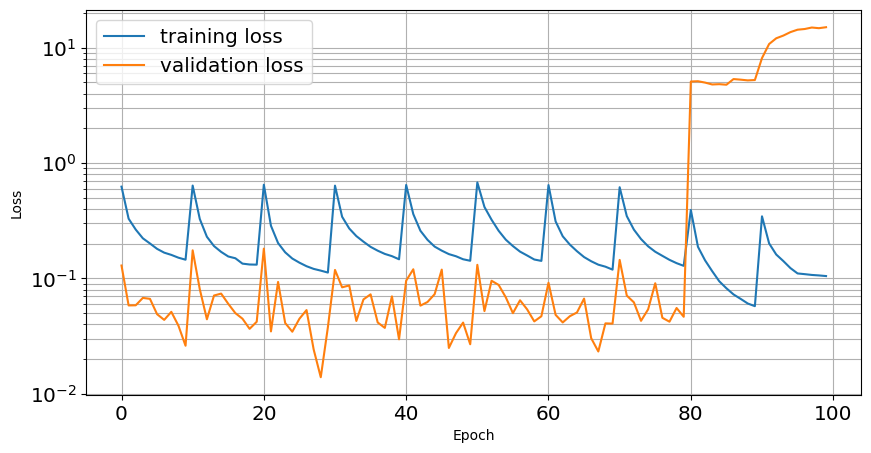

In [26]:
plt.plot(np.arange(len(epoch_train_losses)), epoch_train_losses)
plt.plot(np.arange(len(epoch_val_losses)), epoch_val_losses)
plt.legend(['training loss','validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

## Test the model - Validation set



In [27]:
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for batch_id, (x,y_true) in enumerate(val_loader):
        y_pred = model(x.to(device)).argmax(1)
        
        predictions.extend(y_pred.squeeze().tolist())
        labels.extend(y_true.squeeze().tolist())
        
prediction_labels = pd.DataFrame(np.array([predictions, labels]).T, columns=['Prediction', 'Label'])
cm = prediction_labels.groupby(['Prediction', 'Label']).size()
cm.unstack(0)

Prediction,0.0,1.0,2.0
Label,,,
2.0,263.0,1.0,1419.0
3.0,556.0,1.0,84.0
4.0,2634.0,NaN,3797.0


In [28]:
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3453
         1.0       0.00      0.00      0.00         2
         2.0       0.84      0.27      0.41      5300
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0

    accuracy                           0.16      8755
   macro avg       0.17      0.05      0.08      8755
weighted avg       0.51      0.16      0.25      8755



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.

## Test the model - Test set

In [29]:
test_set = ds(test_df.iloc[:,:-1], test_df.iloc[:,-1])
test_loader = DataLoader(test_set, batch_size=batch_size*4, shuffle=False)

predictions = []

model.eval()
with torch.no_grad():
    for fold in range(n_splits):
        model = Model().to(device)
        model.load_state_dict(torch.load(f'model_fold_{fold}.pth'))
        model.eval()
        
        fold_predictions = []
        labels = []
        for batch_id, (x,y_true) in enumerate(test_loader):
            y_pred = model(x.to(device)).argmax(1)

            fold_predictions.extend(y_pred.squeeze().tolist())
            labels.extend(y_true.squeeze().tolist())
        predictions.append(fold_predictions)
    
predictions.append(labels)
all_prediction_labels = pd.DataFrame(
    np.array(predictions).T, 
    columns=[f'fold {n}' for n in range(n_splits)] + ['Label']
#     columns=['fold 0', 'fold 1', 'fold 2','fold 3','fold 4', 'Label'],
#     columns=['fold 0', 'fold 1', 'fold 3', 'Label']
)

final_predictions = all_prediction_labels.iloc[:,:-1].mode(1).iloc[:,0]
prediction_labels = pd.DataFrame(
    np.hstack([
        final_predictions.values.reshape(-1,1), 
        all_prediction_labels.loc[:,'Label'].values.reshape(-1,1)]
    ),
    columns=['Prediction', 'Label']
)
prediction_labels

cm = prediction_labels.groupby(['Prediction', 'Label']).size()
cm.unstack(0)

Prediction,0.0,1.0,2.0,3.0,4.0
Label,,,,,
0.0,18060.0,19.0,32.0,2.0,5.0
1.0,240.0,305.0,9.0,NaN,2.0
2.0,135.0,1.0,1298.0,11.0,3.0
3.0,72.0,NaN,15.0,75.0,NaN
4.0,78.0,NaN,12.0,NaN,1518.0


Because our goal of this project is not to optimize the model's accuracy, we believed the weighted average of precision, recall, and f-1 score are good for our model. We had to make one change from the MidTerm report with the AdaptiveMaxPool1D layer because of its difficulty implementing in hardware. As a result we went with additional MaxPool1D layers instead. This led to a slight decrease in accuracy and the other scores below. 

In [30]:
predictions = prediction_labels.loc[:,'Prediction'].values
labels = prediction_labels.loc[:,'Label'].values
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     18585
         1.0       0.55      0.94      0.69       325
         2.0       0.90      0.95      0.92      1366
         3.0       0.46      0.85      0.60        88
         4.0       0.94      0.99      0.97      1528

    accuracy                           0.97     21892
   macro avg       0.77      0.94      0.83     21892
weighted avg       0.98      0.97      0.97     21892

